# Table of Contents
 <p><div class="lev1"><a href="#MultiLayer-NN"><span class="toc-item-num">1&nbsp;&nbsp;</span>MultiLayer NN</a></div>

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy

In [6]:
import theano

In [7]:
from theano import pp

In [8]:
import theano.tensor as T

In [9]:
from theano import function

In [10]:
import pickle
import gzip
import base64

def load_data():
    f = gzip.open('data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load((f))
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """
    ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    """
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e



# MultiLayer NN

In [14]:
class Neural_Network_PM(object):
    def __init__(self, arch):        
        #Define Hyperparameters
        self.num_layers = len(arch)
        self.input_layer_size = arch[0]
        self.output_layer_size = arch[-1]
        self.num_hidden_layers = len(arch)-2
        self.costs = []
        
        #Weights map from Layer n to n-1
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(arch[:-1], arch[1:])]
        
    def forward(self, X):
        #Return the output of the network if X is the input
        for w in zip(self.weights):
            X = self.sigmoid(np.dot(w, X))
        return X
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoid_prime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def cost_function(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        self.costs.append(J) 
        return J
    
    def cost_function_by_epoch(self, test_data, n_test):
        y_hat = [(np.argmax(n_net.forward(x))) for (x, y) in test_data[0:n_test]]
        y = [(y) for (x, y) in test_data[0:n_test]]
        #[a - b for a, b in zip([3, 7], [1, 2])]
        costs = [0.5*((a - b)**2) for a, b in zip(y, y_hat)]
        self.costs.append(sum(costs)/n_test)
        return self.costs[-1]
    
    def SGD_incremental(self, training_data, epochs, learning_rate, test_data=None):
        """Train the neural network using gradient descent, one sample at a time. 
        If ``test_data`` is provided then the network will be evaluated against 
        the test data after each epoch"""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            for k in xrange(0, n):
                next_sample = training_data[k:k+1]
                self.process_batch(next_sample, learning_rate)     
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))                
            else:
                print ("Epoch {0} complete".format(j))
                
    def SGD_batchwise(self, training_data, epochs, batch_size, learning_rate,
            test_data=None):
        """Train the neural network using batch-wise 
        gradient descent. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            batches = [
                training_data[k:k+batch_size]
                for k in xrange(0, n, batch_size)]
            for batch in batches:
                self.process_batch(batch, learning_rate)
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))
            else:
                print ("Epoch {0} complete".format(j))
 
    def GD(self, training_data, epochs, learning_rate, test_data=None):
        """Train the neural network using batch-wise 
        gradient descent. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            self.process_input(training_data, learning_rate)
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))
            else:
                print ("Epoch {0} complete".format(j))
                
    def process_input(self, batch, learning_rate):
        """Update the network's weights by applying
        gradient descent using backpropagation to a single batch.
        """
        base_w = [np.zeros(w.shape) for w in self.weights]
        count=0
        eta=learning_rate   
        for x, y in batch:
            delta_error_w = self.backprop(x, y)
            updated_w = [nw+dnw for nw, dnw in zip(base_w, delta_error_w)]
            self.weights = [w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, updated_w)]
            count=count+1
        print ("Process {0} inputs backprop ".format(count))    
                
        
    def process_batch(self, batch, learning_rate):
        """Update the network's weights by applying
        gradient descent using backpropagation to a single batch.
        """
        base_w = [np.zeros(w.shape) for w in self.weights]
        count=0
        for x, y in batch:
            delta_error_w = self.backprop(x, y)
            updated_w = [nw+dnw for nw, dnw in zip(base_w, delta_error_w)]
            count=count+1
        print ("Process {0} inputs backprop ".format(count))    
        eta=learning_rate   
        self.weights = [w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, updated_w)]
        
    def backprop(self, x, y):
        """Return ``( delta_w)`` representing the
        gradient for the cost function C_x. """
        delta_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the activation (z) vectors, layer by layer
        for w in (self.weights):
            z = np.dot(w, activation)
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        #print "delta is: "
        #print delta    
        delta_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            #print "sp is: "
            #print sp
            #print "first part of dot operation is: "
            #print self.weights[-l].transpose() 
            step1 = np.dot(self.weights[-l+1].transpose(), delta)
            #print "step 1 is:"
            #print step1
            delta = step1 * sp
            delta_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (delta_w)

    def evaluate(self, test_data, n_test):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        self.cost_function_by_epoch(test_data, n_test)
        test_results = [(np.argmax(self.forward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)          

New code from scratch based on Theano

In [15]:
from theano.tensor.nnet import sigmoid
from theano.tensor import tanh


class MLP(object):
    def __init__(self, arch):        
        #Define Hyperparameters
        self.num_layers = len(arch)
        self.input_layer_size = arch[0]
        self.output_layer_size = arch[-1]
        self.num_hidden_layers = len(arch)-2 #discounting the input (first) and output (last) layers
        self.costs = []
        
        #Weights map from Layer n to n-1
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(arch[:-1], arch[1:])]
        
        W_value = numpy.asarray(
            rng.uniform(
                low=-numpy.sqrt(6. / (x + y)),
                high=numpy.sqrt(6. / (x + y)),
                size = (x ,y) for x, y in zip(arch[:-1], arch[1:])
            )
        )
        
        W = theano.shared(values=W_value, name='W', borrow=True)
        
        b_values = numpy.zeros((,), dtype=theano.config.floatX)
        b = theano.shared(value=b_values, name='b', borrow=True)
   
        
        self.W = W
        
    def forward(self, X):
        #Return the output of the network if X is the input
        for w in zip(self.weights):
            X = self.sigmoid(np.dot(w, X))
        return X
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoid_prime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def cost_function(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        self.costs.append(J) 
        return J
    
    def cost_function_by_epoch(self, test_data, n_test):
        y_hat = [(np.argmax(n_net.forward(x))) for (x, y) in test_data[0:n_test]]
        y = [(y) for (x, y) in test_data[0:n_test]]
        #[a - b for a, b in zip([3, 7], [1, 2])]
        costs = [0.5*((a - b)**2) for a, b in zip(y, y_hat)]
        self.costs.append(sum(costs)/n_test)
        return self.costs[-1]
    
    def SGD_incremental(self, training_data, epochs, learning_rate, test_data=None):
        """Train the neural network using gradient descent, one sample at a time. 
        If ``test_data`` is provided then the network will be evaluated against 
        the test data after each epoch"""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            for k in xrange(0, n):
                next_sample = training_data[k:k+1]
                self.process_batch(next_sample, learning_rate)     
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))                
            else:
                print ("Epoch {0} complete".format(j))
                
    def SGD_batchwise(self, training_data, epochs, batch_size, learning_rate,
            test_data=None):
        """Train the neural network using batch-wise 
        gradient descent. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            batches = [
                training_data[k:k+batch_size]
                for k in xrange(0, n, batch_size)]
            for batch in batches:
                self.process_batch(batch, learning_rate)
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))
            else:
                print ("Epoch {0} complete".format(j))
 
    def GD(self, training_data, epochs, learning_rate, test_data=None):
        """Train the neural network using batch-wise 
        gradient descent. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            self.process_input(training_data, learning_rate)
            if test_data:
                print ("Epoch {0}: Score {1} / {2}".format(j, self.evaluate(test_data, n_test), n_test))
            else:
                print ("Epoch {0} complete".format(j))
                
    def process_input(self, batch, learning_rate):
        """Update the network's weights by applying
        gradient descent using backpropagation to a single batch.
        """
        base_w = [np.zeros(w.shape) for w in self.weights]
        count=0
        eta=learning_rate   
        for x, y in batch:
            delta_error_w = self.backprop(x, y)
            updated_w = [nw+dnw for nw, dnw in zip(base_w, delta_error_w)]
            self.weights = [w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, updated_w)]
            count=count+1
        print ("Process {0} inputs backprop ".format(count))    
                
        
    def process_batch(self, batch, learning_rate):
        """Update the network's weights by applying
        gradient descent using backpropagation to a single batch.
        """
        base_w = [np.zeros(w.shape) for w in self.weights]
        count=0
        for x, y in batch:
            delta_error_w = self.backprop(x, y)
            updated_w = [nw+dnw for nw, dnw in zip(base_w, delta_error_w)]
            count=count+1
        print ("Process {0} inputs backprop ".format(count))    
        eta=learning_rate   
        self.weights = [w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, updated_w)]
        
    def backprop(self, x, y):
        """Return ``( delta_w)`` representing the
        gradient for the cost function C_x. """
        delta_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the activation (z) vectors, layer by layer
        for w in (self.weights):
            z = np.dot(w, activation)
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        #print "delta is: "
        #print delta    
        delta_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            #print "sp is: "
            #print sp
            #print "first part of dot operation is: "
            #print self.weights[-l].transpose() 
            step1 = np.dot(self.weights[-l+1].transpose(), delta)
            #print "step 1 is:"
            #print step1
            delta = step1 * sp
            delta_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (delta_w)

    def evaluate(self, test_data, n_test):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        self.cost_function_by_epoch(test_data, n_test)
        test_results = [(np.argmax(self.forward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)          

SyntaxError: invalid syntax (<ipython-input-15-b638208ec67e>, line 22)

In [18]:
n_net = Neural_Network_PM([784, 10, 10])

In [17]:
for w in n_net.weights :
    print "Weights Matrix:"
    pcolor(w)
    colorbar()
    print w.shape
    plt.matshow(w)
    colorbar()

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-17-52cffe717f25>, line 2)

In [19]:

training_data, validation_data, test_data = load_data_wrapper()

UnicodeDecodeError: 'ascii' codec can't decode byte 0x90 in position 614: ordinal not in range(128)

In [20]:
#costs = [0.5*(sum(y-n_net.forward(x))) for (x, y) in training_data[48000:]]
y = [(np.argmax(n_net.forward(x))) for (x, y) in test_data[500:1000]]
y_hat = [(y) for (x, y) in test_data[500:1000]]
costs = 0.5*((y-y_hat)**2)
print costs


SyntaxError: Missing parentheses in call to 'print' (<ipython-input-20-392302c24a02>, line 5)

In [21]:
#n_net.SGD_incremental(training_data[40000:], 2, 1.5, test_data=test_data)

In [22]:
#n_net.SGD_batchwise(training_data[500:], 1000, 1000, 1.5, test_data=test_data)

In [23]:
n_net.GD(training_data[1000:], 4, 5000, test_data=test_data)

NameError: name 'training_data' is not defined

In [53]:
X=training_data[5000:]
n_net.process_input(X[0:], 2)


Process 45000 inputs backprop 


In [175]:
#costs = [0.5*(sum(y-n_net.forward(x))) for (x, y) in training_data[48000:]]
y = [(np.argmax(n_net.forward(x))) for (x, y) in test_data[9500:]]
y_hat = [(y) for (x, y) in test_data[9500:]]
costs = 0.5*((y-y_hat)**2)

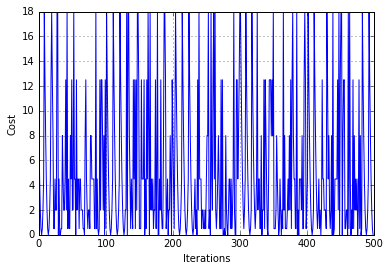

In [176]:
plot(costs)
grid(1)
xlabel('Iterations')
ylabel('Cost')

Weights Matrix:
(10, 784)
Weights Matrix:
(10, 10)


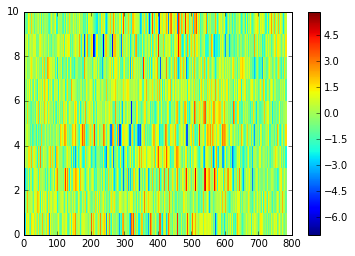

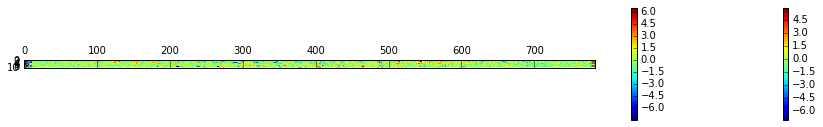

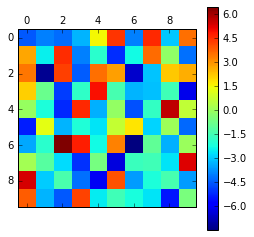

In [177]:
for w in n_net.weights :
    print "Weights Matrix:"
    pcolor(w)
    colorbar()
    print w.shape
    plt.matshow(w)
    colorbar()

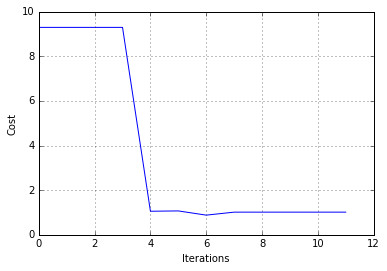

In [62]:
plot(n_net.costs)
grid(1)
xlabel('Iterations')
ylabel('Cost')

TODO:
-bias vs variance
-rbf neural network
-svm kernals